# Comparison of ERA5 and IMD Monthly Rainfall Across Indian States (2000–2024)

In this notebook, we analyze and compare **monthly precipitation patterns** across Indian states using two key datasets:
- ERA5 (climate reanalysis from ECMWF)
- IMD (Indian Meteorological Department gridded rainfall data)

We focus on:
- Harmonizing ERA5 and IMD rainfall data at the **state level**
- Evaluating the **correlation between ERA5 and IMD rainfall** for each state
- Visualizing the **spatial pattern of Pearson correlations** to assess agreement between datasets

We use:
- `varunayan` for extracting ERA5 monthly precipitation (2000–2024)
- `imdlib` for downloading IMD monthly rainfall data

This study provides insights into how well ERA5 captures regional rainfall variability in India compared to IMD observations, which could be important for validating ERA5 use in climate research and studies for India.

## Step 1: Extract ERA5 Rainfall Data for India

We use `varunayan` to download **monthly total precipitation (`tp`)** from the ERA5 climate reanalysis dataset for the Indian region from **2000 to 2024**.

* **North:** 37.5°, **South:** 6°, **East:** 97.5°, **West:** 68°
* **Resolution:** 0.25°
* **Frequency:** Monthly
* **Units:** meters/day

We will be using the raw data acquired using `varunayan` for this analysis.

In [2]:
import varunayan
import pandas as pd
 
varunayan.era5ify_bbox(
    request_id='rainfall_Indian_region',
    variables=['total_precipitation'],
    start_date='2000-1-1',
    end_date='2024-12-31',
    north=37.5,
    south=6,
    east=97.5,
    west=68,
    frequency='monthly',
    resolution=0.25
)


STARTING ERA5 SINGLE LEVEL PROCESSING
Request ID: rainfall_Indian_region
Variables: ['total_precipitation']
Date Range: 2000-01-01 to 2024-12-31
Frequency: monthly
Resolution: 0.25°


90d066f69455fe62ad5ba066ba138b9b.zip:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

5872f417c2db62948dd5fb8983febe50.zip:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

636c8e5597450516c0aae55a252c762e.zip:   0%|          | 0.00/2.49M [00:00<?, ?B/s]


Saving files to output directory: rainfall_Indian_region_output
  Saved final data to: rainfall_Indian_region_output\rainfall_Indian_region_monthly_data.csv
  Saved unique coordinates to: rainfall_Indian_region_output\rainfall_Indian_region_unique_latlongs.csv
  Saved raw data to: rainfall_Indian_region_output\rainfall_Indian_region_raw_data.csv

PROCESSING COMPLETE

RESULTS SUMMARY:
----------------------------------------
Variables processed: 1
Time period:         2000-01-01 to 2024-12-31
Final output shape:  (300, 3)
Total complete processing time: 151.79 seconds

First 5 rows of aggregated data:
         tp  year  month
0  0.036963  2000      1
1  0.033683  2000      2
2  0.044679  2000      3
3  0.055403  2000      4
4  0.128061  2000      5

ERA5 SINGLE LEVEL PROCESSING COMPLETED SUCCESSFULLY


,tp,year,month
0,0.036963,2000,1
1,0.033683,2000,2
2,0.044679,2000,3
3,0.055403,2000,4
4,0.128061,2000,5
...,...,...,...
295,0.261888,2024,8
296,0.177968,2024,9
297,0.133740,2024,10
298,0.088298,2024,11


## Step 2: Process ERA5 Monthly Rainfall Data

We process the downloaded ERA5 dataset to compute **total monthly rainfall** in millimeters and aggregate it at the **state level**.

### Key steps:

1. **Convert to Monthly Rainfall (mm)**

   * Multiply `tp` (meters/day) by number of days in month × 1000
   * Final unit: **millimeters per month**

2. **Assign State Names to Grid Points**

   * Convert each `(lat, lon)` point to a `Point` geometry
   * Perform a **spatial join** with Indian district boundaries to assign the corresponding state

3. **Statewise Monthly Aggregation**

   * Compute the **rainfall per state per month**

The result is a dataframe (`statewise_monthly_prec_era5`) with:

* `month`, `state_name`, `monthly_rain_mm`

In [3]:
df_raw_prec = pd.read_csv('rainfall_Indian_region_output/rainfall_Indian_region_raw_data.csv')

In [4]:
import numpy as np

df_raw_prec['month'] = pd.to_datetime(df_raw_prec['date']).dt.month
df_raw_prec['date'] = pd.to_datetime(df_raw_prec['date'])
df_raw_prec['days_in_month'] = df_raw_prec['date'].dt.days_in_month

# Convert tp (precipitation in m/day) -> total monthly precipitation (in meters) -> total monthly precipitation (in mm)
df_raw_prec['tp'] = df_raw_prec['tp'] * df_raw_prec['days_in_month'] * 1000

In [5]:
import geopandas as gpd
from shapely.geometry import Point

df_raw_prec['geometry'] = df_raw_prec.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
gdf_prec = gpd.GeoDataFrame(df_raw_prec, geometry='geometry', crs='EPSG:4326')

In [6]:
url = "https://bharatviz.saketlab.in/India_LGD_Districts_simplified.geojson"
districts_gdf = gpd.read_file(url)

In [7]:
gdf_joined = gpd.sjoin(
    gdf_prec,
    districts_gdf[['state_name', 'geometry']],
    how='left',
    predicate='within'
)

gdf_joined = gdf_joined.dropna(subset=['state_name'])

In [8]:
statewise_monthly_prec_era5 = (
    gdf_joined.groupby(['date', 'state_name'], as_index=False)['tp'].mean()
    .rename(columns={'tp': 'monthly_rain_mm'})
)

statewise_monthly_prec_era5

,date,state_name,monthly_rain_mm
0,2000-01-01,A & N Islands,38.449201
1,2000-01-01,Andhra Pradesh,1.987584
2,2000-01-01,Arunachal Pradesh,147.174445
3,2000-01-01,Assam,32.347206
4,2000-01-01,Bihar,1.555414
...,...,...,...
10495,2024-12-01,Telangana,19.974696
10496,2024-12-01,Tripura,0.528455
10497,2024-12-01,Uttar Pradesh,17.636980
10498,2024-12-01,Uttarakhand,51.980734


In [9]:
statewise_monthly_prec_era5.to_csv('era5_monthly_statewise_rain.csv', index=False)

## Step 3: Extract IMD Gridded Rainfall Data

We use the `imdlib` package to download **gridded IMD rainfall** data over India for the same period: **2000–2024**.

* Variable: `'rain'`
* Format: `monthwise`
* Grid resolution: 0.25°
* Units: mm

This dataset provides **observational rainfall data** from IMD's high-quality station network.


In [10]:
import imdlib as imd

start_yr = 2000
end_yr = 2024
variable = 'rain'
imd.get_data(variable, start_yr, end_yr, fn_format='monthwise')

Downloading: rain for year 2000
Downloading: rain for year 2001
Downloading: rain for year 2002
Downloading: rain for year 2003
Downloading: rain for year 2004
Downloading: rain for year 2005
Downloading: rain for year 2006
Downloading: rain for year 2007
Downloading: rain for year 2008
Downloading: rain for year 2009
Downloading: rain for year 2010
Downloading: rain for year 2011
Downloading: rain for year 2012
Downloading: rain for year 2013
Downloading: rain for year 2014
Downloading: rain for year 2015
Downloading: rain for year 2016
Downloading: rain for year 2017
Downloading: rain for year 2018
Downloading: rain for year 2019
Downloading: rain for year 2020
Downloading: rain for year 2021
Downloading: rain for year 2022
Downloading: rain for year 2023
Downloading: rain for year 2024
Download Successful !!!


## Step 4: Process IMD Data to Statewise Monthly Rainfall

We convert the IMD gridded dataset into a **statewise monthly rainfall** dataset to match the format of ERA5.

### Key steps:

1. **Convert to DataFrame**

   * Extract data from the `xarray` object
   * Drop missing values (`-999.0`)

2. **Aggregate Monthly Rainfall**

   * Sum rainfall for each month at each grid point
   * Create Point geometries and spatially join with state boundaries

3. **Statewise Monthly Average**

   * Group by `state_name` and `month`
   * Calculate average monthly rainfall

Output: `statewise_monthly_prec_imd`

In [11]:
import numpy as np

data = imd.open_data(variable, start_yr, end_yr,'monthwise')
ds = data.get_xarray()
df = ds.to_dataframe().reset_index()
df['rain'] = df['rain'].replace(-999.0, np.nan)
df

,time,lat,lon,rain
0,2000-01-01,6.5,66.50,NaN
1,2000-01-01,6.5,66.75,NaN
2,2000-01-01,6.5,67.00,NaN
3,2000-01-01,6.5,67.25,NaN
4,2000-01-01,6.5,67.50,NaN
...,...,...,...,...
159033775,2024-12-31,38.5,99.00,NaN
159033776,2024-12-31,38.5,99.25,NaN
159033777,2024-12-31,38.5,99.50,NaN
159033778,2024-12-31,38.5,99.75,NaN


In [13]:
df['time'] = pd.to_datetime(df['time'])
df['month'] = df['time'].dt.to_period('M')
grouped_df = df.groupby(['month', 'lat', 'lon'], as_index=False)['rain'].sum()
grouped_df

,month,lat,lon,rain
0,2000-01,6.5,66.50,0.0
1,2000-01,6.5,66.75,0.0
2,2000-01,6.5,67.00,0.0
3,2000-01,6.5,67.25,0.0
4,2000-01,6.5,67.50,0.0
...,...,...,...,...
5224495,2024-12,38.5,99.00,0.0
5224496,2024-12,38.5,99.25,0.0
5224497,2024-12,38.5,99.50,0.0
5224498,2024-12,38.5,99.75,0.0


In [14]:
import geopandas as gpd
from shapely.geometry import Point

df = grouped_df.copy()
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
grid_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

In [15]:
joined = gpd.sjoin(grid_gdf, districts_gdf[['state_name', 'geometry']], how='left', predicate='within')

In [16]:
statewise_monthly_prec_imd = joined.groupby(['month','state_name'], as_index=False)['rain'].mean()
statewise_monthly_prec_imd = statewise_monthly_prec_imd.dropna(subset=['state_name'])
statewise_monthly_prec_imd

,month,state_name,rain
0,2000-01,A & N Islands,0.000000
1,2000-01,Andhra Pradesh,0.055613
2,2000-01,Arunachal Pradesh,35.826280
3,2000-01,Assam,19.927342
4,2000-01,Bihar,0.523257
...,...,...,...
10495,2024-12,Telangana,17.484431
10496,2024-12,Tripura,5.540522
10497,2024-12,Uttar Pradesh,4.986236
10498,2024-12,Uttarakhand,31.285862


In [17]:
statewise_monthly_prec_imd.to_csv('imd_monthly_statewise_rain.csv', index=False)

## Step 5: Merge ERA5 and IMD Datasets

We merge the two statewise monthly rainfall datasets (`ERA5` and `IMD`) into a common format for comparison.

* Align on: `month`, `state_name`
* Rename columns to:

  * `rain_imd` (from IMD)
  * `rain_era5` (from ERA5)

Final merged dataset: `merged_df`


In [18]:
statewise_monthly_prec_imd['month'] = statewise_monthly_prec_imd['month'].dt.to_timestamp()

statewise_monthly_prec_era5['date'] = pd.to_datetime(statewise_monthly_prec_era5['date'])
statewise_monthly_prec_era5 = statewise_monthly_prec_era5.rename(columns={'date': 'month'})

merged_df = pd.merge(
    statewise_monthly_prec_imd,
    statewise_monthly_prec_era5,
    on=['month', 'state_name'],
    how='left'
)


In [19]:
merged_df = merged_df.rename(columns={
    'rain': 'rain_imd',
    'monthly_rain_mm': 'rain_era5'
})

merged_df.to_csv('merged_imd_era5_state_rain.csv', index=False)

In [20]:
merged_df

,month,state_name,rain_imd,rain_era5
0,2000-01-01,A & N Islands,0.000000,38.449201
1,2000-01-01,Andhra Pradesh,0.055613,1.987584
2,2000-01-01,Arunachal Pradesh,35.826280,147.174445
3,2000-01-01,Assam,19.927342,32.347206
4,2000-01-01,Bihar,0.523257,1.555414
...,...,...,...,...
10495,2024-12-01,Telangana,17.484431,19.974696
10496,2024-12-01,Tripura,5.540522,0.528455
10497,2024-12-01,Uttar Pradesh,4.986236,17.636980
10498,2024-12-01,Uttarakhand,31.285862,51.980734


## Step 6: Compute Statewise Pearson Correlation

We compute the **Pearson correlation coefficient** between ERA5 and IMD rainfall for each state using the merged dataset.

* Group by `state_name`
* Calculate correlation between `rain_imd` and `rain_era5`
* Drop states with insufficient data (e.g., all-zero IMD values)

Final output: `statewise_corr` with:

* `state_name`, `pearson_corr`


In [21]:
statewise_corr = (
    merged_df
    .dropna(subset=['rain_imd', 'rain_era5'])
    .groupby('state_name')
    .apply(lambda df: df.loc[:, ['rain_imd', 'rain_era5']].corr().iloc[0,1])
    .reset_index(name='pearson_corr')
)

statewise_corr.to_csv('statewise_corr_imd_era5.csv', index=False)

C:\Users\Atharva Jagtap\AppData\Local\Temp\ipykernel_6688\3483317820.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.loc[:, ['rain_imd', 'rain_era5']].corr().iloc[0,1])


In [28]:
def setup_matplotlib():
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError(
            "Matplotlib is not installed. Install it with: pip install matplotlib"
        )

    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial"]
    plt.rcParams["axes.labelweight"] = "normal"

    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["mathtext.rm"] = "Arial"
    plt.rcParams["mathtext.it"] = "Arial:italic"
    plt.rcParams["mathtext.bf"] = "Arial:bold"

## Visualize Correlation as Bar Plot

We visualize the **statewise Pearson correlations** using a horizontal bar chart.

* Sort states by correlation
* Highlight high agreement (closer to 1.0)
* Filter out NaN values (e.g., A & N Islands)

C:\Users\Atharva Jagtap\AppData\Local\Temp\ipykernel_6688\2650763813.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




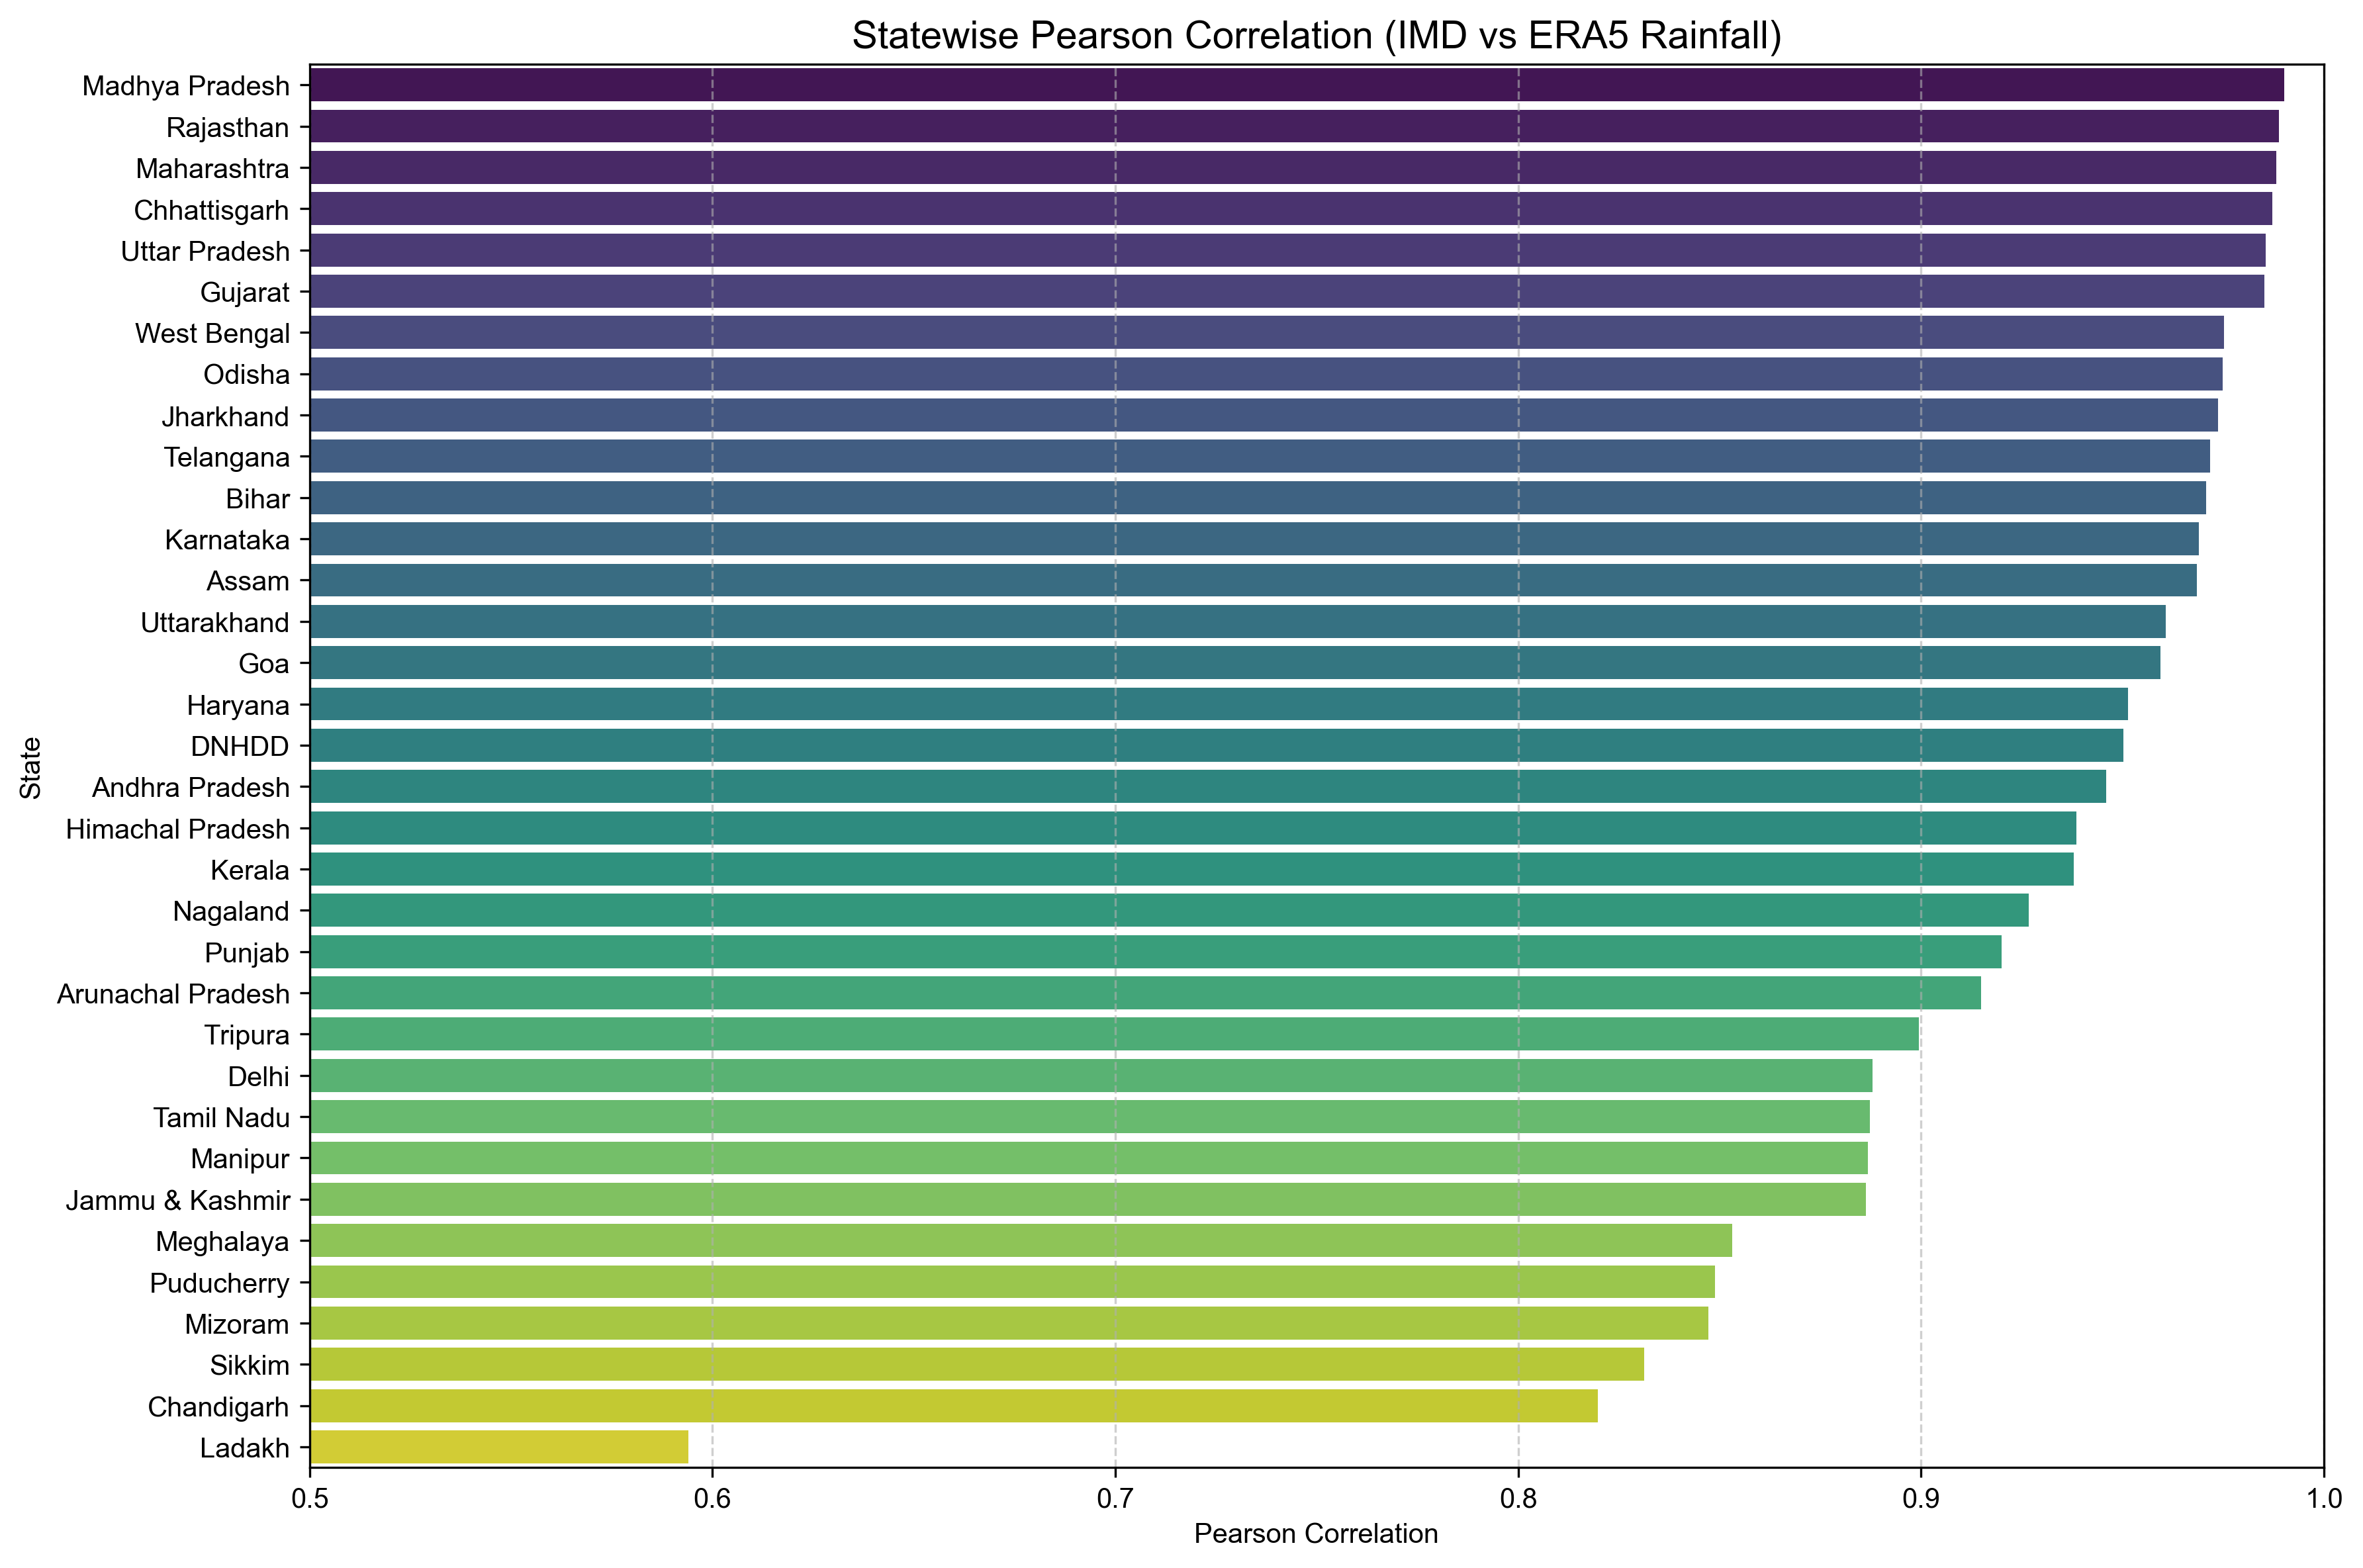

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

setup_matplotlib()

# Clean NaNs (for A & N Islands, since all the values for rainfall in IMD data are 0)
statewise_corr = statewise_corr.dropna(subset=['pearson_corr'])

statewise_corr_sorted = statewise_corr.sort_values('pearson_corr', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=statewise_corr_sorted, x='pearson_corr', y='state_name', palette='viridis')

plt.title('Statewise Pearson Correlation (IMD vs ERA5 Rainfall)', fontsize=14)
plt.xlabel('Pearson Correlation')
plt.ylabel('State')
plt.xlim(0.5, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Choropleth Map of Correlation by State

We use a simplified **India state GeoJSON** to create a choropleth map showing the **spatial pattern of correlation** between ERA5 and IMD rainfall.

### Features:

* Color scale (`coolwarm`) for correlation values
* State labels and correlation values annotated

This visualization gives a spatial perspective on how well ERA5 agrees with IMD across different regions of India.

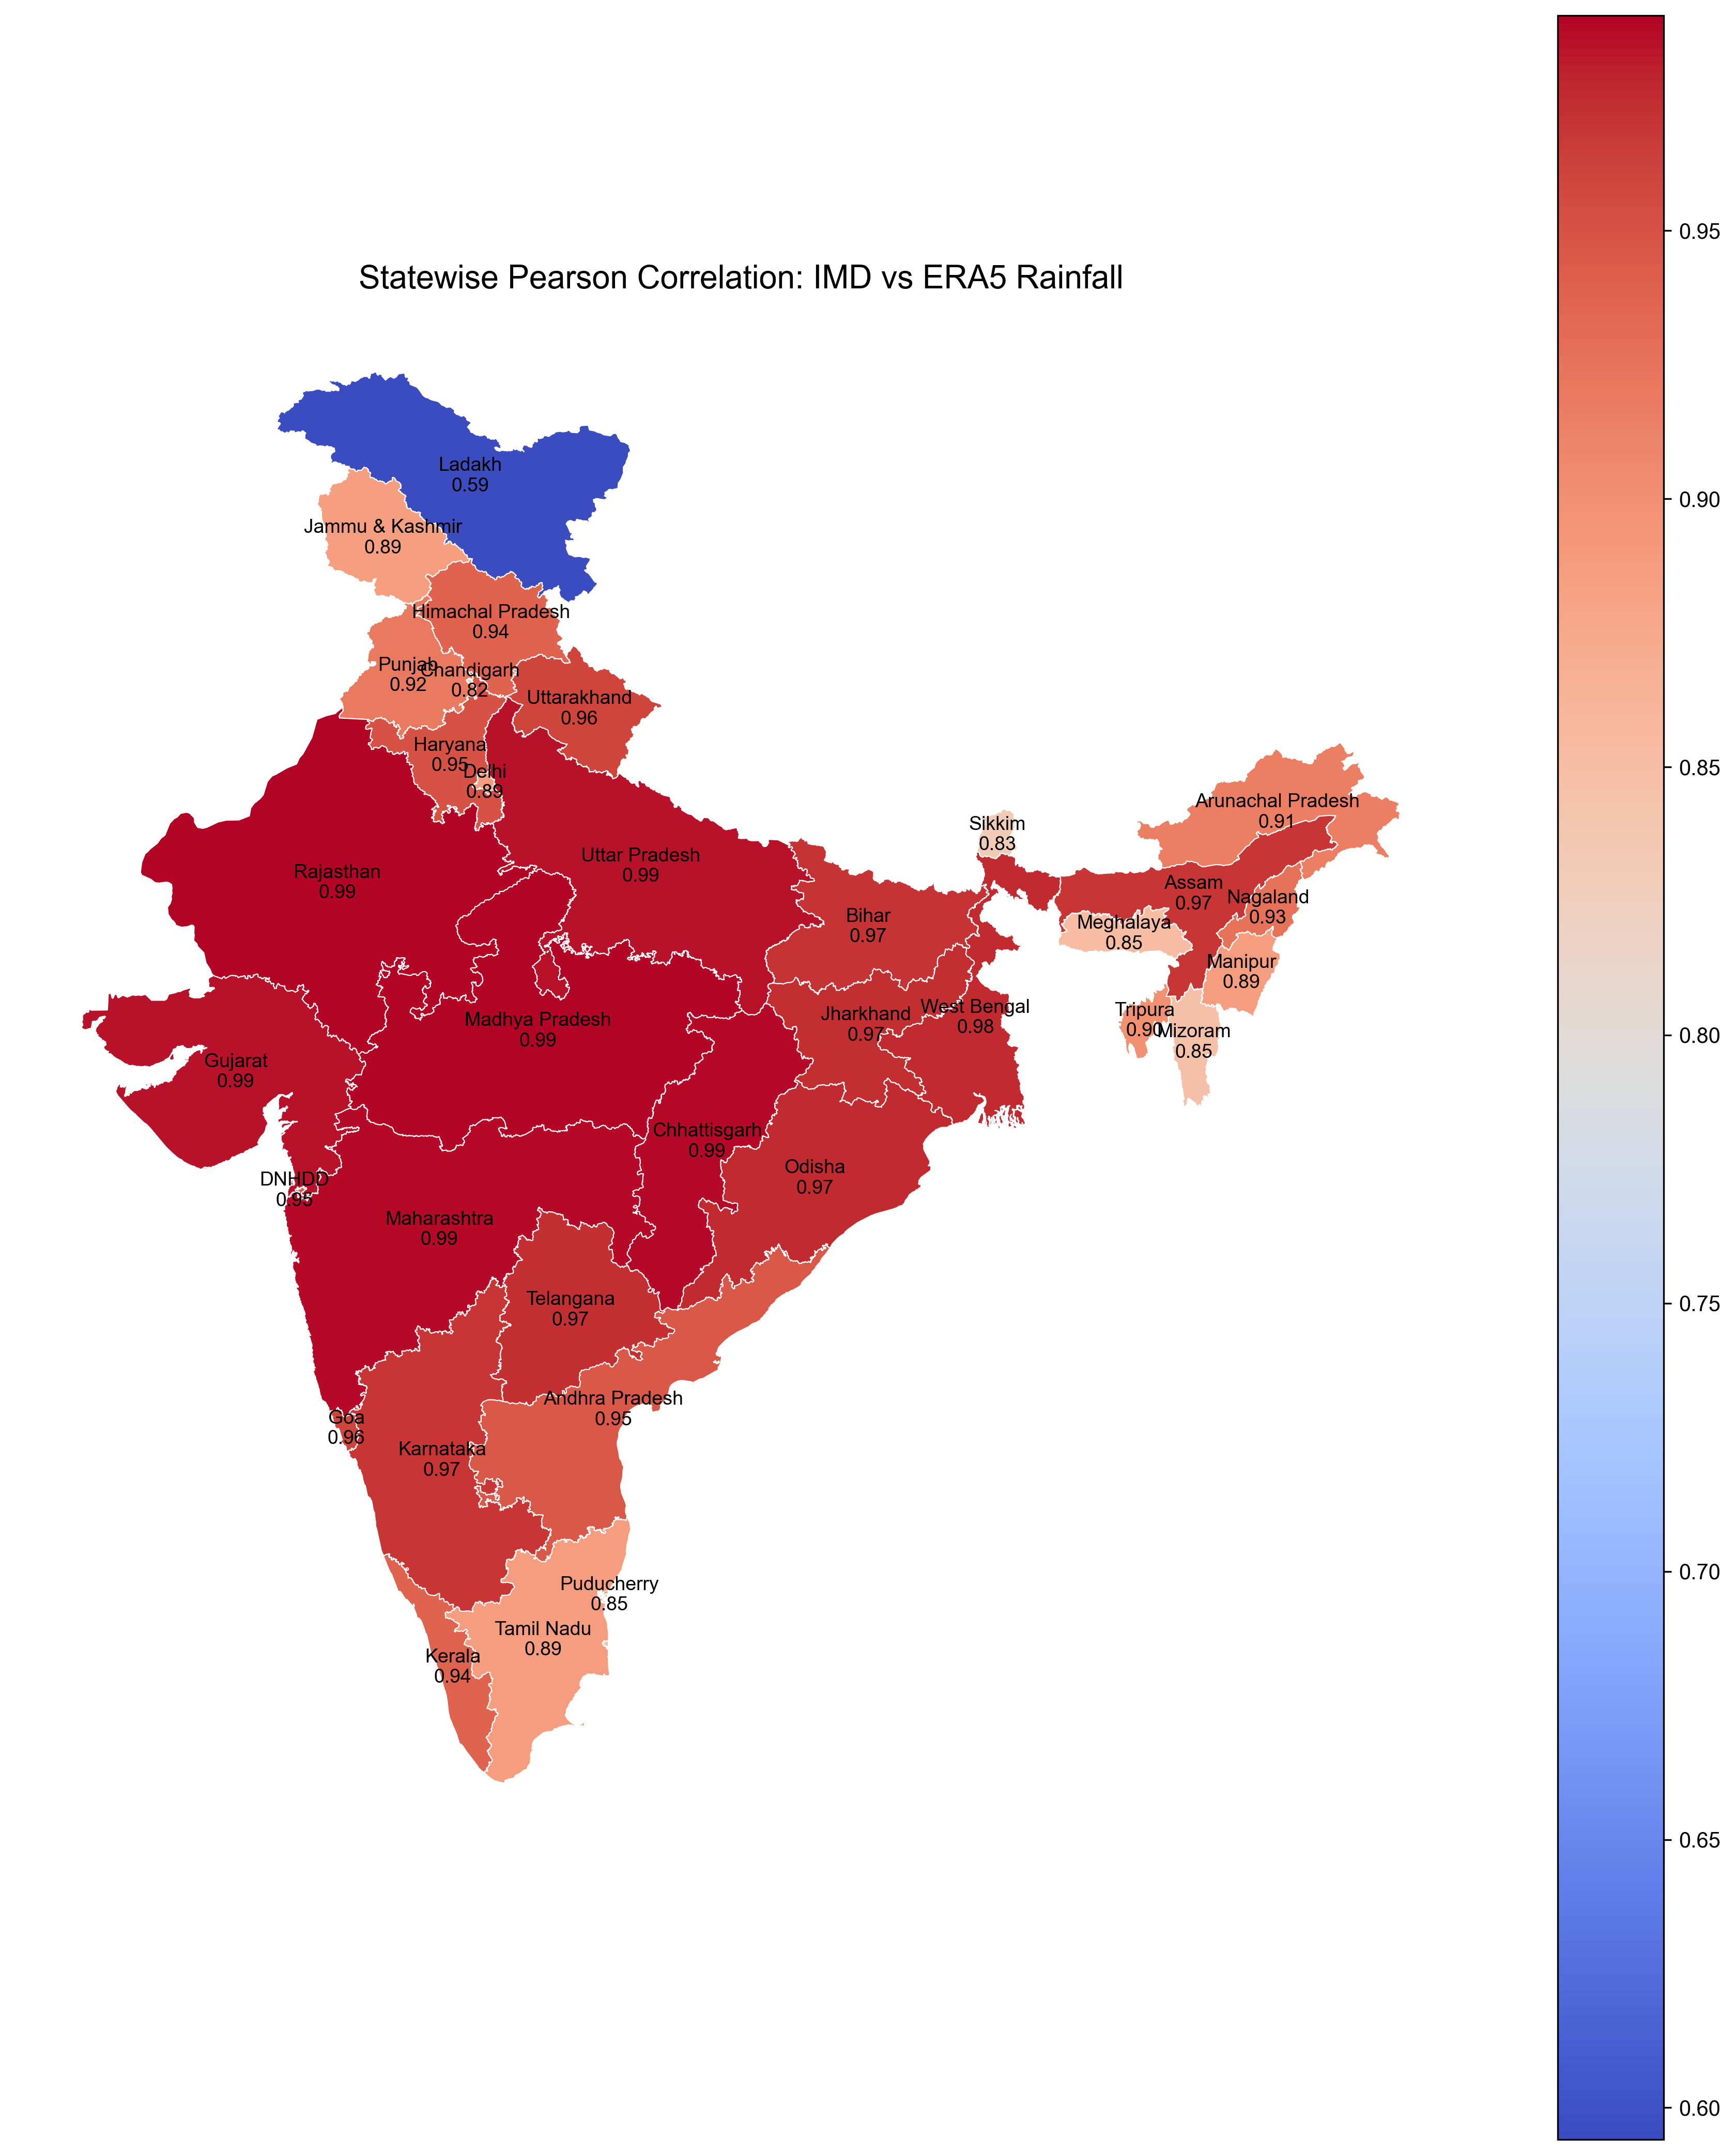

In [59]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

setup_matplotlib()

geojson_url = "https://gist.githubusercontent.com/JaggeryArray/fa31964eedb0c2da023c9485772f911a/raw/02c0644de34fbae9dbac2ba0496a00772a2c28cd/india_map_states.geojson"
gdf = gpd.read_file(geojson_url)

gdf_merged = gdf.merge(statewise_corr, on='state_name', how='left')

fig, ax = plt.subplots(figsize=(12, 14))
gdf_merged.plot(
    column='pearson_corr',
    cmap='coolwarm',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)

for idx, row in gdf_merged.dropna(subset=['pearson_corr']).iterrows():
    centroid = row.geometry.centroid
    label = f"{row['state_name']}\n{row['pearson_corr']:.2f}"
    ax.text(centroid.x, centroid.y, label, fontsize=9, ha='center', va='center')

ax.set_title("Statewise Pearson Correlation: IMD vs ERA5 Rainfall", fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()
